## Imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Set random seed for reproducibility


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Dataset

In [ ]:
class MetadataDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.isic_ids = self.data['isic_id']
        self.labels = self.data['target']
        self.features = self.data.drop(columns=['isic_id', 'target']).values.astype(np.float32)

        # Encode labels if they are not already numeric
        if self.labels.dtype != np.int64:
            self.labels = LabelEncoder().fit_transform(self.labels)
        self.labels = self.labels.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx])

## Hyperparams

In [ ]:
batch_size = 64
learning_rate = 1e-3
num_epochs = 50
hidden_dim = 1024
dropout = 0.5
output_dim = 2  

## Data Loading and Splitting

In [ ]:
csv_file = '../data/balanced_data/normalized_metadata.csv'
dataset = MetadataDataset(csv_file)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Architecture Definition

In [6]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(FeedforwardNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

## Init

In [ ]:

input_dim = dataset[0][0].shape[0]  
model = FeedforwardNN(input_dim, hidden_dim, output_dim, dropout)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


## Training

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def save_best_model(epoch, model, optimizer, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)


In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, 'best_model.pth')  

for epoch in range(num_epochs):
    
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    train_acc = running_corrects / len(train_loader.dataset)
    train_accuracies.append(train_acc)

    
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    val_acc = running_corrects / len(val_loader.dataset)
    val_accuracies.append(val_acc)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_best_model(epoch, model, optimizer, best_model_path)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/50 - Train Loss: 0.7103, Train Acc: 0.5157, Val Loss: 0.6306, Val Acc: 0.7867
Epoch 2/50 - Train Loss: 0.5934, Train Acc: 0.7035, Val Loss: 0.5318, Val Acc: 0.7200
Epoch 3/50 - Train Loss: 0.4926, Train Acc: 0.7628, Val Loss: 0.5063, Val Acc: 0.7600
Epoch 4/50 - Train Loss: 0.4662, Train Acc: 0.7727, Val Loss: 0.5216, Val Acc: 0.7200
Epoch 5/50 - Train Loss: 0.4293, Train Acc: 0.7990, Val Loss: 0.4946, Val Acc: 0.7600
Epoch 6/50 - Train Loss: 0.4121, Train Acc: 0.8171, Val Loss: 0.4853, Val Acc: 0.7200
Epoch 7/50 - Train Loss: 0.4045, Train Acc: 0.8237, Val Loss: 0.4660, Val Acc: 0.7600
Epoch 8/50 - Train Loss: 0.3696, Train Acc: 0.8468, Val Loss: 0.4855, Val Acc: 0.7600
Epoch 9/50 - Train Loss: 0.3796, Train Acc: 0.8353, Val Loss: 0.4712, Val Acc: 0.7600
Epoch 10/50 - Train Loss: 0.3548, Train Acc: 0.8386, Val Loss: 0.4979, Val Acc: 0.7200
Epoch 11/50 - Train Loss: 0.3599, Train Acc: 0.8451, Val Loss: 0.5031, Val Acc: 0.7333
Epoch 12/50 - Train Loss: 0.3552, Train Acc: 0.8550,

## Eval

In [ ]:
def custom_metric(y_true, y_pred_proba, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.
    """
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    max_fpr = 1 - min_tpr
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred_proba  

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

In [ ]:

print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()
y_true, y_pred, y_pred_proba = [], [], []

test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        test_corrects += torch.sum(preds == labels).item()


test_loss /= len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("Test Classification Report:")
print(classification_report(y_true, y_pred))


partial_auc = custom_metric(y_true, y_pred_proba, min_tpr=0.8)
print(f"Partial AUC (pAUC): {partial_auc:.4f}")



Loading best model from: saved_models/best_model.pth
Test Loss: 0.4455, Test Accuracy: 0.7662
Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        33
           1       0.91      0.66      0.76        44

    accuracy                           0.77        77
   macro avg       0.79      0.78      0.77        77
weighted avg       0.80      0.77      0.77        77

Partial AUC (pAUC): 0.1233


## Plot

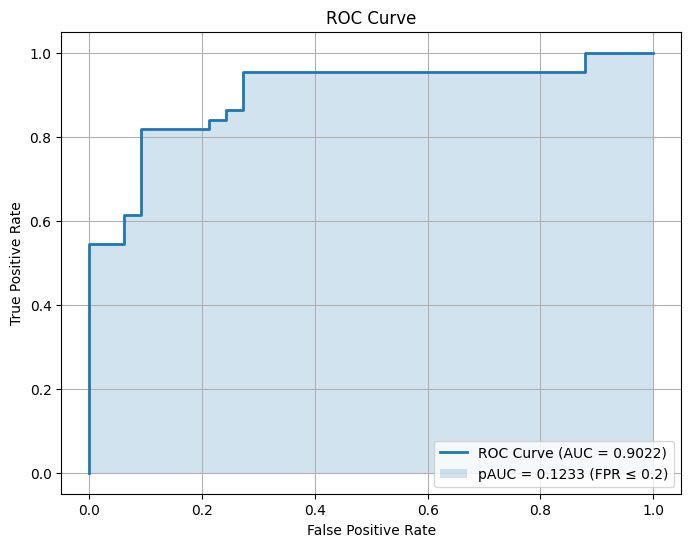

ROC Curve saved at: saved_models/roc_curve.png


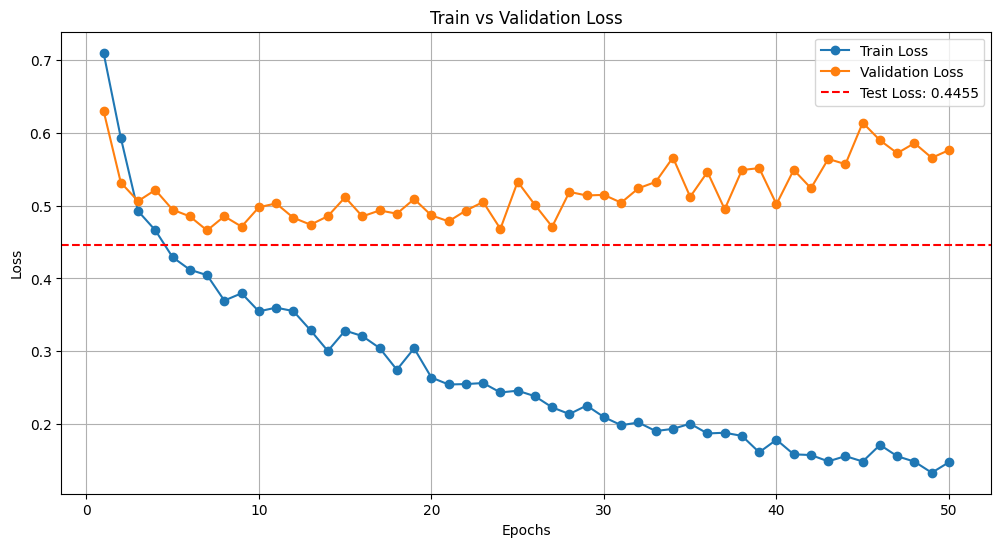

Train vs Validation Loss plot saved at: saved_models/train_val_loss.png


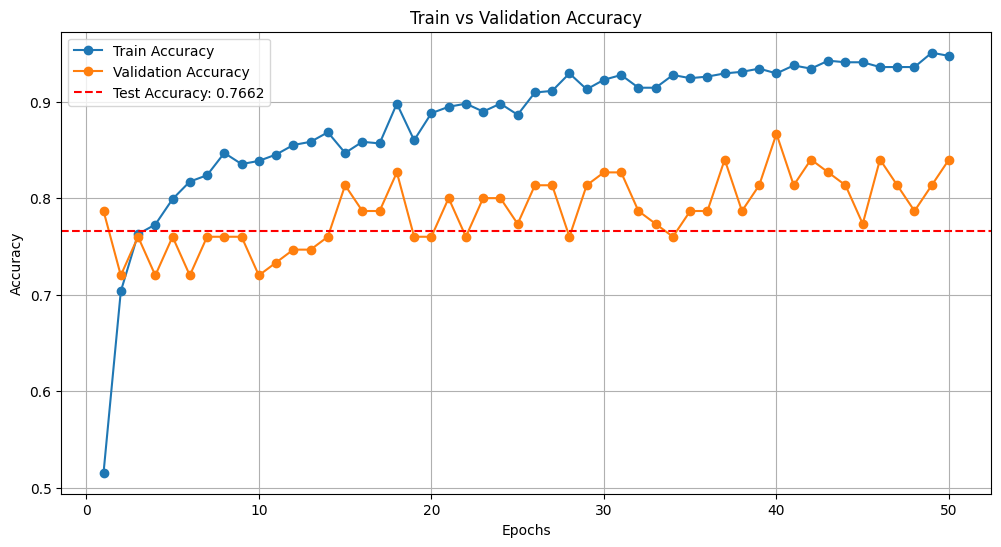

Train vs Validation Accuracy plot saved at: saved_models/train_val_accuracy.png


In [ ]:

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.4f})", linewidth=2)
plt.fill_between(fpr, tpr, alpha=0.2, label=f"pAUC = {partial_auc:.4f} (TPR >= 0.8)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
roc_curve_path = os.path.join(model_dir, "roc_curve.png")
plt.savefig(roc_curve_path, bbox_inches="tight")
plt.show()
print(f"ROC Curve saved at: {roc_curve_path}")


plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(model_dir, "train_val_loss.png")
plt.savefig(loss_plot_path, bbox_inches="tight")
plt.show()
print(f"Train vs Validation Loss plot saved at: {loss_plot_path}")


plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
accuracy_plot_path = os.path.join(model_dir, "train_val_accuracy.png")
plt.savefig(accuracy_plot_path, bbox_inches="tight")
plt.show()
print(f"Train vs Validation Accuracy plot saved at: {accuracy_plot_path}")


## Save Model Params

In [ ]:

params_file_path = os.path.join(model_dir, "model_params.txt")
with open(params_file_path, "w") as f:
    f.write("Model Architecture:\n")
    f.write(str(model) + "\n\n")  
    
    f.write("Hyperparameters:\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Dropout: {dropout}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: CrossEntropyLoss\n\n")
    
    f.write("Training Results:\n")
    f.write(f"Final Train Loss: {train_losses[-1]:.4f}\n")
    f.write(f"Final Train Accuracy: {train_accuracies[-1]:.4f}\n\n")

    f.write("Validation Results:\n")
    f.write(f"Best Validation Loss: {best_val_loss:.4f}\n")
    f.write(f"Best Validation Accuracy: {max(val_accuracies):.4f}\n\n")

    f.write("Test Results:\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Partial AUC (pAUC): {partial_auc:.4f}\n")
    f.write(f"ROC AUC: {roc_auc_score(y_true, y_pred_proba):.4f}\n")
    
print(f"Model parameters and architecture saved to {params_file_path}")


Model parameters and architecture saved to saved_models/model_params.txt
